# Lesson 3: Accessing Data Using Open Geospatial Consortium (OGC) Services

**Objective:** Access data using Open Geospatial Consortium (OGC) standard services such as **Environmental Data Retreival (EDR)**, **Tiles**, and **WMS**.

In first two workbooks of this repository, the focus has been on accessing raw underlying geospatial data living in an s3 bucket. While STAC catalogs seen in the second workbook allowed us to more easily search large and complex repositories of data, we were using them to pull individual files of interest (in that case as Cloud Optimized GeoTIFFs) into our working environment.

An alternative to accessing these data in their raw formats is through the utilization of web services and standards, which abstract the underlying data  away from us as end users, and allow us to interact with the data in a way that (hopefully) facilitates easier usage of these data in our workflows.

Examples of well established services in the geospatial world are the **Web Map Service (WMS)** and **Web Feature Service (WFS)**, both maintained by the Open Geospatial Consortium (OGC). A full list of OGC Standards can be found on their website, here: https://www.ogc.org/standards/. While the OGC is a major driver for the development of these standards, it's interesting to note that often times the geospatial community itself (both in industry and academia) develop protocols and formats that become _defacto_ community standards as their adoption grows. One example of this is the STAC specification utilized in the second workbook. This spec started independently of the OGC, and has become more and more utilized in the EO-space. It has now been brought into the [OGC as a "Community Standard"](https://www.ogc.org/announcement/ogc-announces-publication-of-the-spatiotemporal-asset-catalog-community-standards/).

## TNC Use Case: Human Modification Index Dataset

One great example of the usage of OGC Services at TNC can be seen through the work of TNC Spatial Data Scientist, [Glenn Moncrieff](https://github.com/GMoncrieff). Glenn and his collaborators are stewards of the Human Modification (HM) Index dataset. This dataset is defined in that team's own words as:

> The Global Human Modification (HM) index [Theobald et al 2025](https://www.nature.com/articles/s41597-025-04892-2) measures the impact of human activities on nature by quantifying the distribution and intensity of 14 threats globally. It ranges from 0 (no human impact) to 1 (maximum human impact). These 14 threats are summarized into a single cumulative index representing the overall impact of human activities on nature.

![03_HMI_Inputs.png](./assets/03_HMI_Inputs.png)

**Image Reference:** https://www.nature.com/articles/s41597-025-04892-2/figures/1

The HM dataset spans a global spatial extent, at five year intervals, for time periods ranging from 1990-2020. Glenn and his team are working on augmenting this index of observations with forecasts from to 2040. For this forecast scenario, data are represented in three parameters `lower - 2.5 percent quantile HM forecast`, `middle - 50 percent quantile HM forecast`, and `upper - 97.5 percent quantile HM forecast`.

Similar to the Sentinel-2 imagery in the previous workbook, these data could be represented as a series of raster files covering the globe for each combination of time period and parameter of the dataset. However, the raw data have been loaded into Earthmover Arraylake as a cube, allowing them to be interacted with directly using the python `xarray` library.

Additionally - Glenn has put together a number of compelling examples using the OGC Environmental Data Retrieval (EDR) and OGC Tiles services. These services allow end users to interact with the data in a more precise and hopefully easier way. These endpoints are exposed by loading these underlying data into the [Arraylake platform provided by Earthmover ](https://earthmover.io/). Below are some re-imagining of the examples Glenn has put together, for use in a python notebook.

## Environmental Data Retrieval

One way of extracting a precise subset of a large dataset such as the HM is to use the [OGC Environmental Data Retrieval (EDR) API](https://ogcapi.ogc.org/edr/).

This API allows us to query data from the HM for a given point, polygon, or cube (combination of bbox and date). Additionally, the EDR API implementation used by Arraylake (where the HMI data are stored) allows us to extract data in a variety of easy to consume formats such as: CSV, GeoJSON, GeoTIFF, NetCDF.

Let's take a look below at some examples to query these data.

## EDR Point Query

Run the cell below to query the HM dataset's `50 percent quantile HM forecast` value for a particular X/Y Point.

As these data are aligned to common X/Y/Date axes, our point query returns results for all available years for that point.

In [1]:
import requests
from IPython.display import JSON, display

edr_point_url = "https://compute.earthmover.io/v1/services/edr/the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/edr/position?coords=POINT(-76.25705765451062%2036.870170628129785)&parameter-name=middle"

edr_point_data = requests.get(edr_point_url).json()
display(edr_point_data)

{'type': 'Coverage',
 'domain': {'type': 'Domain',
  'domainType': 'Grid',
  'axes': {'x': {'values': [-76.2615]},
   'y': {'values': [36.86850000000001]},
   'date': {'values': ['1990-01-01T00:00:00',
     '1995-01-01T00:00:00',
     '2000-01-01T00:00:00',
     '2005-01-01T00:00:00',
     '2010-01-01T00:00:00',
     '2015-01-01T00:00:00',
     '2020-01-01T00:00:00',
     '2025-01-01T00:00:00',
     '2030-01-01T00:00:00',
     '2035-01-01T00:00:00',
     '2040-01-01T00:00:00']},
   'spatial_ref': {'values': [0]}},
  'referencing': []},
 'parameters': {'middle': {'type': 'Parameter',
   'observedProperty': {'label': {'en': '50 percent quantile HM forecast'}},
   'description': {'en': '50 percent quantile HM forecast'},
   'unit': {}}},
 'ranges': {'middle': {'type': 'NdArray',
   'dataType': 'float',
   'axisNames': ['date', 'y', 'x'],
   'shape': [11, 1, 1],
   'values': [0.9527000188827515,
    0.9520999789237976,
    0.9520999789237976,
    0.9521999955177307,
    0.9523000121116638,

## EDR Area Query

Similar to the point query, an `EDR Area Query` allows you to specify an arbitrary polygon. For simplicity we're using a closed rectangle over Madrid in the query below. Additionally, we can query the data in a variety of formats. See below for examples returning the same data as a CSV, and a GeoJSON file. Note that we are also including a `date` parameter, constraining our returned result set to a single "slice" of data within the cube.

In [2]:
import pandas as pd

edr_area_base_url = "https://compute.earthmover.io/v1/services/edr/the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/edr/area"
edr_area_params = {
    "coords": "POLYGON((-3.97644 40.70160,-3.97644 40.05628,-3.35782 40.05628,-3.35782 40.70160,-3.97644 40.70160))",
    "date": "2030-01-01",
    "f": "csv",
    "parameter-name": "middle"
}

edr_area_request = requests.PreparedRequest()
edr_area_request.prepare_url(edr_area_base_url, edr_area_params)

edr_area_df = pd.read_csv(edr_area_request.url)
edr_area_df

date   pts    middle  longitude  latitude  spatial_ref
0     2030-01-01     0  0.553570    -3.9735   40.0635            0
1     2030-01-01     1  0.523217    -3.9645   40.0635            0
2     2030-01-01     2  0.539487    -3.9555   40.0635            0
3     2030-01-01     3  0.551496    -3.9465   40.0635            0
4     2030-01-01     4  0.534858    -3.9375   40.0635            0
...          ...   ...       ...        ...       ...          ...
4894  2030-01-01  4894  0.577415    -3.3975   40.6935            0
4895  2030-01-01  4895  0.433975    -3.3885   40.6935            0
4896  2030-01-01  4896  0.552377    -3.3795   40.6935            0
4897  2030-01-01  4897  0.623313    -3.3705   40.6935            0
4898  2030-01-01  4898  0.628642    -3.3615   40.6935            0

[4899 rows x 6 columns]

In [ ]:
import geopandas as gpd

edr_area_params["f"] = "geojson"

edr_area_request.prepare_url(edr_area_base_url, edr_area_params)

edr_area_geodf = gpd.read_file(edr_area_request.url)

# Convert `date` column to string for geopandas popup.
edr_area_geodf['date'] = edr_area_geodf['date'].dt.strftime('%Y-%m-%dT%H:%M:%S%z')

edr_area_geodf.explore(
    column="middle",
    tiles="CartoDB positron",
    cmap="turbo"
)

ERROR 1: PROJ: proj_create_from_database: Open of /home/sagemaker-user/.conda/envs/ocs-intermediate-binder/share/proj failed


## EDR Cube Query (GeoTIFF Support)

Lastly, we can extract these same data as a GeoTIFF a via an EDR Cube Query. Specific to this EDR service provider, Earthmover, GeoTIFFs are not supported by the `Area` query used above, since it can take a polygon with an arbitrary number of vertices as input. The cube query specifically requires a bbox param with the following format:

`{base_url}/cube?bbox={min_x},{min_y},{max_x},{max_y}`

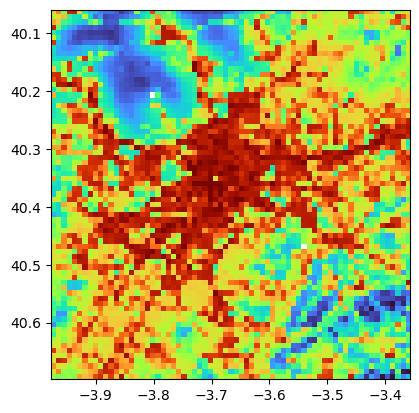

In [4]:
import rasterio
from rasterio.plot import show

edr_cube_base_url="https://compute.earthmover.io/v1/services/edr/the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/edr/cube" 
edr_cube_params = {
    "bbox": "-3.97644,40.05628,-3.35782,40.70160",
    "f": "geotiff",
    "parameter-name": "middle",
    "date": "2030-01-01"
}
edr_cube_request = requests.PreparedRequest()
edr_cube_request.prepare_url(edr_cube_base_url, edr_cube_params)
with rasterio.open(edr_cube_request.url) as raster_dataset:
    show(raster_dataset, cmap="turbo", origin="lower")

## Tiles

For visualization purposes, the [OGC API - Tiles standard](https://ogcapi-workshop.ogc.org/api-deep-dive/tiles/) can be a great way to allow users to quickly view data on a slippy map, for their area of interest. When used in conjunction with a slippy map library such as [maplibre](https://maplibre.org/) or [mapbox gl js](https://docs.mapbox.com/mapbox-gl-js/guides/), tiles are only requested for the area and zooms that the user navigates to within the map interface.

Additionally, the slippy map can be augmented with other layers to provide additional context.

**First:** Let's create a map of the HM dataset using the python [folium library](https://python-visualization.github.io/folium/latest/).

In [5]:
import folium

# STEP ONE: Add our HMI dataset Tiles endpoint
attr = ("TNC Human Modification Index Data - Hosted On Arraylake")
hmi_tiles_url = "https://compute.earthmover.io/v1/services/tiles/" \
                "the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/tiles" \
                "/WebMercatorQuad/{z}/{y}/{x}?variables=middle&date=2030-01-01T00:00:00" \
                "&colorscalerange=0,1&style=raster/turbo&width=512&height=512"
m = folium.Map(
    max_bounds=True,
    location=(40.4178, -3.7063),
    attr=attr,
    tiles=hmi_tiles_url,
    zoom_start=9,
    min_zoom=8,
    max_zoom=10,
    min_lat=38.44,
    max_lat=42.46,
    min_lon=-7.94,
    max_lon=0.7
)
m

**Second:** Let's add in a boundary dataset from TNC's public facing [Countries Where We Work](https://services.arcgis.com/F7DSX1DSNSiWmOqh/ArcGIS/rest/services/TNC_Countries/FeatureServer/3) Feature Service on ArcGIS Online.

In [6]:
import folium
import requests

# STEP ONE: Add our HMI dataset Tiles endpoint
attr = ("TNC Human Modification Index Data - Hosted On Arraylake")
hmi_tiles_url = "https://compute.earthmover.io/v1/services/tiles/" \
                "the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/tiles" \
                "/WebMercatorQuad/{z}/{y}/{x}?variables=middle&date=2030-01-01T00:00:00" \
                "&colorscalerange=0,1&style=raster/turbo&width=512&height=512"

m = folium.Map(
    max_bounds=True,
    location=(48.232, 16.388),
    attr=attr,
    tiles=hmi_tiles_url,
    zoom_start=7,
    min_zoom=6,
    max_zoom=8,
    min_lat=37.335,
    max_lat=56.607,
    min_lon=--2.065,
    max_lon=35.507
)

# STEP TWO: Add TNC Boundaries Dataset from ArcGIS Online
tnc_country_boundaries = requests.get(
    "https://services.arcgis.com/F7DSX1DSNSiWmOqh/ArcGIS/rest/services/TNC_Countries/FeatureServer/0/query?where=1%3D1&objectIds=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&outDistance=&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnEnvelope=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&collation=&orderByFields=&groupByFieldsForStatistics=&returnAggIds=false&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="
).json()
folium.GeoJson(
    tnc_country_boundaries,
    name="TNC Boundaries",
    style_function=lambda feature: {
        "color": "red",
        "weight": 2
    }).add_to(m)

folium.LayerControl().add_to(m)
m

**Third:**, we can leverage our EDR endpoint to give us the value of our HM data at the location of user's click. This value can then be displayed in a popup.

**NOTE:** in this example, enabling a click event in a popup of a `folium` map running within a python cell of a Jupyter notebook, is definitely a bit hacky.

I relied on Microsoft Copilot coding assistance to develop the snippet we see in `click_js`. Which is essentially a JavaScript code block injected into `folium`
after the map is loaded.

I suspect the inclusion of a popup dynamically populated with a value is much easier outside of the notebook environment using a tool like [maplibre](https://maplibre.org/) or [mapbox gl js](https://docs.mapbox.com/mapbox-gl-js/guides/)

In [7]:
import folium
import requests

# STEP ONE: Add our HMI dataset Tiles endpoint
attr = ("TNC Human Modification Index Data - Hosted On Arraylake")
hmi_tiles_url = "https://compute.earthmover.io/v1/services/tiles/" \
                "the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/tiles" \
                "/WebMercatorQuad/{z}/{y}/{x}?variables=middle&date=2030-01-01T00:00:00" \
                "&colorscalerange=0,1&style=raster/turbo&width=512&height=512"

m = folium.Map(
    max_bounds=True,
    location=(40.4178, -3.7063),
    attr=attr,
    tiles=hmi_tiles_url,
    zoom_start=9,
    min_zoom=8,
    max_zoom=10,
    min_lat=38.44,
    max_lat=42.46,
    min_lon=-7.94,
    max_lon=0.7
)

# STEP TWO: Add TNC Boundaries Dataset from ArcGIS Online
tnc_country_boundaries = requests.get(
    "https://services.arcgis.com/F7DSX1DSNSiWmOqh/ArcGIS/rest/services/TNC_Countries/FeatureServer/0/query?where=1%3D1&objectIds=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&outDistance=&relationParam=&returnGeodetic=false&outFields=&returnGeometry=true&returnEnvelope=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&defaultSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&collation=&orderByFields=&groupByFieldsForStatistics=&returnAggIds=false&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnTrueCurves=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="
).json()

folium.GeoJson(
    tnc_country_boundaries,
    name="TNC Boundaries",
    style_function=lambda feature: {
        "color": "red",
        "weight": 2
    }).add_to(m)


# STEP THREE: Add click event popup displaying HMI value using EDR Point Query
map_var = m.get_name()  # e.g. "map_4f549ea69ee5baba11f6a42aa453ecea"

API_BASE = "https://compute.earthmover.io/v1/services/edr/the-nature-conservancy/ocs-intermediate-workshop-hmi/main/hm/edr/position"
DEFAULT_DATE = "2015-01-01"
DEFAULT_PARAM = "middle"
FORMAT = "geojson"

# Raw JS (no <script> tags). We append to m.get_root().script so it loads after Folium’s own script.
click_js = f"""
(function initFoliumEDR() {{
  const MAP_VAR_NAME = '{map_var}';

  function log(...args) {{
    console.log('[folium-edr]', ...args);
  }}

  // Retry loop to wait for Leaflet and the Folium map variable
  function waitForMapAndInit(maxAttempts = 200, delayMs = 50) {{
    let attempt = 0;

    function tryInit() {{
      attempt++;
      const hasLeaflet = typeof window.L !== 'undefined';
      const map = window[MAP_VAR_NAME];

      if (!hasLeaflet || !map) {{
        if (attempt < maxAttempts) {{
          return setTimeout(tryInit, delayMs);
        }} else {{
          console.error('[folium-edr] Timed out waiting for map:', MAP_VAR_NAME, 'Leaflet present?', hasLeaflet);
          return;
        }}
      }}

      // At this point, map and Leaflet are available
      attachClickHandler(map);
    }}

    tryInit();
  }}

  function removeLastGeoJSON(map) {{
    if (window._folium_last_geojson_layer) {{
      try {{
        map.removeLayer(window._folium_last_geojson_layer);
      }} catch (e) {{
        console.warn('[folium-edr] removeLayer error:', e);
      }}
      window._folium_last_geojson_layer = null;
    }}
  }}

  function pickFirstFeatureProps(geojson) {{
    if (!geojson || !geojson.type) return null;

    if (geojson.type === 'Feature' && geojson.properties) {{
      return geojson.properties;
    }}

    if (geojson.type === 'FeatureCollection' && Array.isArray(geojson.features) && geojson.features.length > 0) {{
      const f = geojson.features[0];
      return f && f.properties ? f.properties : null;
    }}

    return null;
  }}

  function fmtNum(n, digits = 6) {{
    const x = Number(n);
    if (Number.isFinite(x)) return x.toFixed(digits);
    return String(n);
  }}

  function addGeoJSONAndPopup(map, geojson, clickLatLng) {{
    removeLastGeoJSON(map);

    const layer = L.geoJSON(geojson);
    layer.addTo(map);
    window._folium_last_geojson_layer = layer;

    const props = pickFirstFeatureProps(geojson);
    let content = 'No properties found in GeoJSON.';
    if (props) {{
      const latProp = props.latitude;
      const lonProp = props.longitude;
      const middleProp = props.middle;

      content = `
        <div style="font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; line-height:1.35;">
          <div><b>latitude</b>: ${{fmtNum(latProp)}}</div>
          <div><b>longitude</b>: ${{fmtNum(lonProp)}}</div>
          <div><b>middle</b>: ${{(middleProp != null && isFinite(middleProp)) ? Number(middleProp).toFixed(3) : String(middleProp)}}</div>
        </div>
      `;
    }}

    L.popup({{ maxWidth: 360 }})
      .setLatLng(clickLatLng)
      .setContent(content)
      .openOn(map);
  }}

  function attachClickHandler(map) {{
    log('Map found, attaching click handler to', MAP_VAR_NAME);

    // Avoid stacking when cell is re-run
    map.off('click');

    map.on('click', async (e) => {{
      const lat = e.latlng.lat;  // Leaflet gives lat, lng
      const lng = e.latlng.lng;

      log('Click at', lat, lng);

      // Earthmover expects coords=POINT(X Y) with X=longitude, Y=latitude
      const coordsWKT = `POINT(${{lng}} ${{lat}})`;

      // ⚠️ Important: Do NOT pre-encode, let URLSearchParams encode once.
      // Pre-encoding + searchParams will double-encode (% -> %25).
      const url = new URL('{API_BASE}');
      url.searchParams.set('coords', coordsWKT);
      url.searchParams.set('date', '{DEFAULT_DATE}');
      url.searchParams.set('parameter-name', '{DEFAULT_PARAM}');
      url.searchParams.set('f', '{FORMAT}');

      // If the API is strict about spaces needing %20 instead of '+',
      // you can patch the search string as a fallback:
      // url.search = url.search.replace(/\\+/g, '%20');

      try {{
        const resp = await fetch(url.toString(), {{
          method: 'GET',
          headers: {{
            'Accept': 'application/json'
          }}
        }});
        if (!resp.ok) {{
          throw new Error(`HTTP ${{resp.status}}: ${{resp.statusText}}`);
        }}

        const data = await resp.json();
        log('API response', data);

        addGeoJSONAndPopup(map, data, e.latlng);
      }} catch (err) {{
        console.error('[folium-edr] Error calling API:', err);
        L.popup({{ maxWidth: 380 }})
          .setLatLng(e.latlng)
          .setContent('Error calling API: ' + String(err))
          .openOn(map);
      }}
    }});
  }}

  // Start waiting for the map variable
  waitForMapAndInit();
}})();
"""

# Append AFTER Folium's map init scripts
m.get_root().script.add_child(folium.Element(click_js))

m

## Sidequest: Generating These URLs and Desktop GIS Support

The EDR URLs in these examples might look complicated, and they are, but they do follow a consistent format. That format is documented in both the [Earthmover documentation](https://docs.earthmover.io/flux/edr#edr-url-structure) as well as the actual [OGC EDR spec](https://ogcapi.ogc.org/edr/) in much greater detail.

To make things easier, Earthmover has created a `Data Access` form that allows you to create URLs in a GUI for your repo, such as in the image below:

![03_ArraylakeDataAccessGUI.png](./assets/03_ArraylakeDataAccessGUI.png)

Unlike STAC as we saw in the previous lesson, there isn't good support right now for EDR in Desktop GIS applications like QGIS or ArcGIS Pro. An extension exists for QGIS, but I haven't had good success with it. For use in a Desktop GIS, my suggestion is to generate a URL which extracts a subset of data (cut to a particular study area for example) in a format that works well for your software (e.g NetCDF, GeoTIFF, GeoJSON). Then take that output and load it into your software.

## Conclusions

In this workbook, we've attempted to demonstrate the utility of web services to allow us more convenient access to large raw datasets, in formats that are more fit for purpose for our workflow.

In this example, TNC's Human Modification (HM) Index dataset exists in its raw form as a space-time cube, hosted in TNC's Eathmover Arraylake platform.

Using the OGC Environmental Data Retrieval (EDR) standard, we can create extracts of these data as CSV/GeoJSON/GeoTIFF subset to our exact spatial extent and time of interest.

Using the OGC API Tiles standard, we can tap into the very same underlying data, and use it to power a slippy map to quickly visually explore our data.

Finally, we can create interactive maps integrating both the tiles service for a base layer, EDR point queries for popups, and additional third party data (TNC's Countries Where We Work dataset) for value added context.

Lastly -- To deep dive into Cloud Native spatial analysis workflows, please consider attending the advanced module of this series February 24/February 25.

## Additional Resources

- [Earthmover Arraylake](https://earthmover.io/): Cloud storage platform for multidimensional data.
- [USGS Environmental Data Retreival (EDR) Use Case Tutorial](https://water.usgs.gov/catalog/usecases/77aa3413-3993-4475-93cd-e4f7b5ceecc9/)